In this notebook we define a OU process between two Gaussian process measures.

Consider the following forward SDE
$$
d y(x, t) = 1/2 * (\mu_T(x) - y(x, t)) \beta_t \mathrm{d}t + \sqrt{\beta_t K_T} \mathrm{d}B_t
$$
where $x \in \mathcal{X}^N$ is a set of inputs and $y(x) \in \mathbb{R}$ are the finite marginals. It can be shown that the limiting process is given by $\mathcal{GP}(\mu_T, k_T)$.

We compute the mean and covariance of the multidimensional marginals $p_t(y(x))$ using the Fokker-Planck equations:
$$
\mathbb{E}_y[p_t(y(x))] =  \exp(-1/2 \int_{s=0}^t \beta_s \mathrm{d}s) \mu_0(x) + (1 - \exp(-1/2 \int_{s=0}^t \beta_s \mathrm{d}s)) \mu_T(x) := \mu_t
$$
and
$$
\mathbb{V}\text{ar}_y[p_t(y(x))] = K_T + \exp(- \int_{s=0}^t \beta_s \mathrm{d}s) (K_0 - K_T) := K_t.
$$
From these we can derive the *conditional* mean and covariance when starting the process from a point $y_0$. Set $\mu_0 = y_0$ and $K_0 = 0$, which gives
$$
\mu_{t|0} = \exp(-1/2 \int_{s=0}^t \beta_s \mathrm{d}s) y_0 + (1 - \exp(-1/2 \int_{s=0}^t \beta_s \mathrm{d}s)) \mu_T(x)
$$
and 
$$
K_{t|0} = (1 - \exp(\int_{s=0}^t \beta_s \mathrm{d}s)) K_T.
$$

The *reverse* process is given by
$$
d\bar{y}(x, t) = 1/2 * \beta_t \big(\mu_T(x) - y(x, t)- K_T \nabla_y p_t(y(x))\big) \mathrm{d}t + \sqrt{\beta_t K_T} \mathrm{d}B_t
$$
For which there exist a probability flow ODE
$$
d\bar{y}(x, t) = 1/2 * \beta_t \big(\mu_T(x) - y(x, t)- 2 K_T \nabla_y p_t(y(x))\big) \mathrm{d}t
$$


In this case, where $y_0(x)\sim \mathcal{GP}(\mu_0, k_0)$ we have a closed form expression for the score:

\begin{align*}
\nabla_y p(y(x,t)) &= \nabla_y \mathcal{N}(y | \mu_t, K_t) \\
&= - K_t^{-1} (y - \mu_t)
\end{align*}



In [104]:
from functools import partial
import jax
import jax.numpy as jnp
import diffrax as dfx
import matplotlib.pyplot as plt
import numpy as np

from check_shapes import check_shapes

import neural_diffusion_processes as ndp

In [105]:
from jax.config import config
config.update("jax_enable_x64", True)
JITTER = 1e-12

In [106]:
beta_schedule = ndp.sde.LinearBetaSchedule()
x = jnp.linspace(-1, 1, 103)[:, None]
k0 = ndp.kernels.SquaredExpontialKernel(lengthscale=0.25)
k0 = partial(ndp.kernels.gram, k0)
k1 = ndp.kernels.WhiteKernel()
k1 = partial(ndp.kernels.gram, k1)

# k1 = ndp.kernels.SquaredExpontialKernel(lengthscale=1.0)
mean_function = lambda x: jnp.zeros_like(x)  # A zero mean function

In [107]:
import jax.tree_util as jtu
from neural_diffusion_processes.types import PyTree

class MatVecControlTerm(dfx.ControlTerm):

    @staticmethod
    def prod(vf: PyTree, control: PyTree) -> PyTree:
        return jtu.tree_map(lambda a,b: a @ b, vf, control)

@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, 1]",)
def drift(t, yt, x):
    return  - 0.5 * beta_schedule(t) * (yt - mean_function(x)) # [N, 1]
    
@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, N]",)
def diffusion(t, yt, x):
    del yt
    sqrt_K = jnp.linalg.cholesky(k1(x) + JITTER * jnp.eye(len(x)))
    return jnp.sqrt(beta_schedule(t)) * sqrt_K


def solve(key, y0):
    shape = jax.ShapeDtypeStruct(y0.shape, y0.dtype)
    bm = dfx.VirtualBrownianTree(t0=beta_schedule.t0, t1=beta_schedule.t1, tol=1e-3 / 2., shape=shape, key=key)
    terms = dfx.MultiTerm(dfx.ODETerm(drift), MatVecControlTerm(diffusion, bm))
    t0, t1 = beta_schedule.t0, beta_schedule.t1
    # logarithmic timesteps to have more steps at small timesteps... 
    ts = t0 + (t1 - t0) * (jnp.exp(jnp.linspace(t0, t1, 9)) - jnp.exp(t0)) / (jnp.exp(t1) - jnp.exp(t0))
    ts = jnp.linspace(t0, t1, 9)
    saveat = dfx.SaveAt(ts=ts)
    return dfx.diffeqsolve(terms, solver=dfx.Euler(), t0=t0, t1=t1, dt0=1e-3, y0=y0, args=x, saveat=saveat, adjoint=dfx.NoAdjoint())

In [108]:
def sample_gp(key, kernel, mean, x, num_samples: int = 10):
    return ndp.misc.sample_mvn(key, mean(x), kernel(x), num_samples)

In [109]:
seed = 42
key = jax.random.PRNGKey(seed)

# Solves forward SDE for multiple initia states using vmap.
num_samples = 3
key, subkey = jax.random.split(key)
y0s= sample_gp(subkey, k0, mean_function, x, num_samples=num_samples)
subkeys = jax.random.split(key, num=num_samples)
out = jax.vmap(solve, in_axes=[0, 0])(subkeys, y0s)

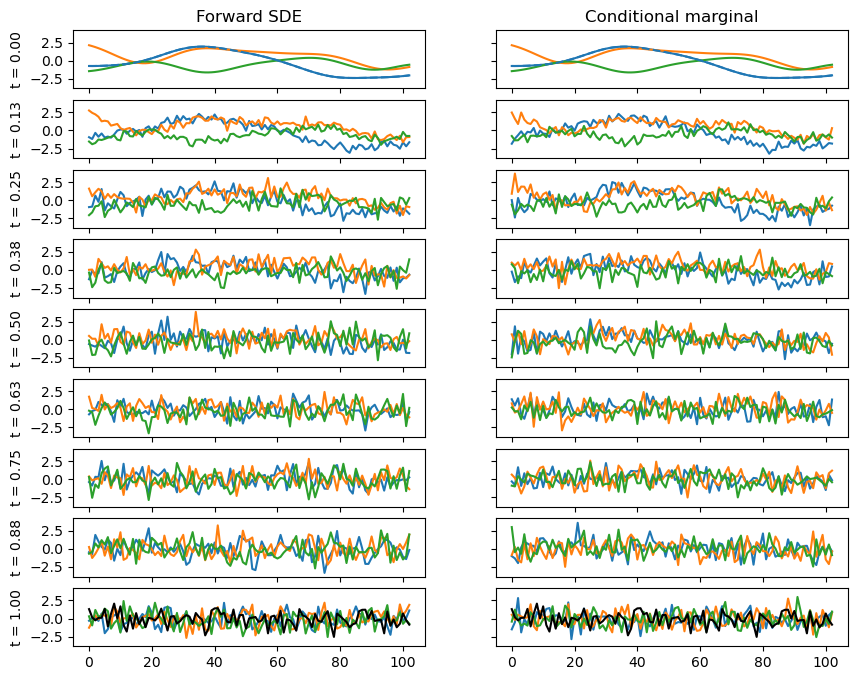

In [110]:
def pt(x, t, y0=None):
    """Marginal of OU process at time t. When passing y0 this returns the conditional marginal."""
    # TODO: change if limiting processes have different mean functions.
    mean0 = mean1 = mean_function
    mean_coef = jnp.exp(-0.5 * beta_schedule.B(t))

    if y0 is None:
        mean = mean_coef * mean0(x) + (1.0 - mean_coef) * mean1(x)
    else:
        mean = mean_coef * y0 + (1.0 - mean_coef) * mean1(x)
    
    if y0 is None:
        cov = k1(x) + jnp.exp(-beta_schedule.B(t)) * (k0(x) - k1(x))
    else:
        cov = (1.0 -  jnp.exp(-beta_schedule.B(t))) * k1(x)
    
    return mean, cov

def sample_pt(key, x, t, y0=None):
    "Marginal distribution p(yt) if y0 is passed p(yt | xt)"
    mean, cov = pt(x, t, y0)
    return ndp.misc.sample_mvn(key, mean, cov)


ys = jnp.transpose(out.ys, [1, 0, 2, 3])  # [time, samples, num_points, 1]
ts = jnp.transpose(out.ts, [1, 0])  # [time, samples]

key, subkey = jax.random.split(key)
fig, axes = plt.subplots(len(ts), 2, figsize=(10, 8), sharex=True, sharey=True)
for t_index in range(len(axes)):
    axes[t_index, 0].set_ylabel(f"t = {ts[t_index, 0]:.2f}")
    axes[t_index, 0].plot(ys[t_index, ..., 0].T)

    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, num_samples)
    marginal_samples = jax.vmap(lambda k, y: sample_pt(k, x, ts[t_index, 0], y0=y), in_axes=[0, 0])(subkeys, y0s)
    for j in range(len(marginal_samples)):
        axes[t_index, 1].plot(marginal_samples[j], f"C{j}")

ref_samples = sample_gp(subkey, k1, mean_function, x, num_samples=None)  # [num_samples, num_points, 1]
axes[-1, 1].plot(ref_samples, "k")
axes[-1, 0].plot(ref_samples, "k")
axes[0, 0].set_title('Forward SDE')
axes[0, 1].set_title('Conditional marginal')
for j in range(y0s.shape[-1]):
    axes[0, 0].plot(y0s[j, :, 0], f"C{j}--")
    axes[0, 1].plot(y0s[j, :, 0], f"C{j}--")


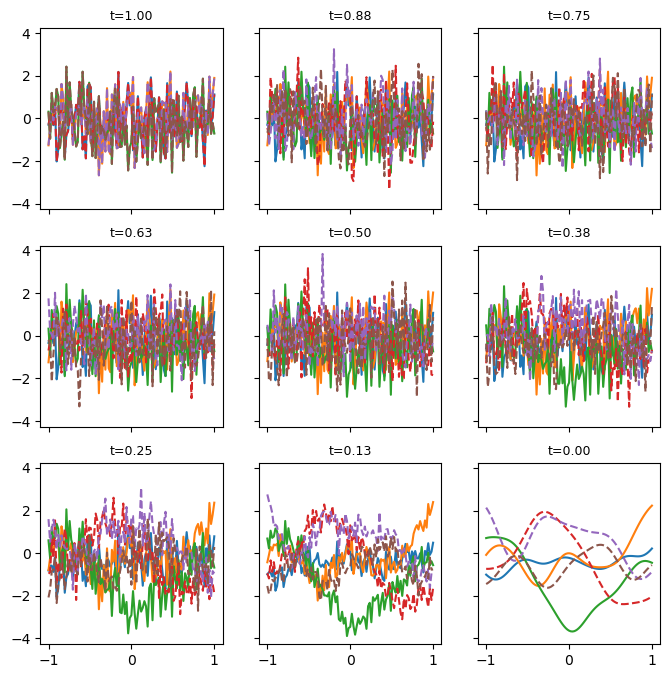

In [111]:

solve_lower_triangular = partial(jax.scipy.linalg.solve_triangular, lower=True)  # L⁻¹ x
solve_upper_triangular = partial(jax.scipy.linalg.solve_triangular, lower=False)  # U⁻¹ x

@check_shapes("yt: [N, 1]", "x: [N, 1]", "t: []", "return: [N, 1]",)
def preconditioned_score(yt, x, t):
    "Exact marginal score in Gaussian setting"
    mu_t, Sigma_t = pt(x, t)
    Lt = jnp.linalg.cholesky(Sigma_t + JITTER * jnp.eye(len(Sigma_t)))
    b = yt - mu_t
    A = solve_upper_triangular(jnp.transpose(Lt), solve_lower_triangular(Lt, b))
    return - k1(x) @ A


@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, 1]",)
def reverse_drift_ode(t, yt, x):
    return  drift(t, yt, x) - 0.5 * beta_schedule(t) * preconditioned_score(yt, x, t) # [N, 1]

def reverse_drift_sde(t, yt, x):
    return  drift(t, yt, x) - beta_schedule(t) * preconditioned_score(yt, x, t) # [N, 1]


def reverse_solve(key, yT, prob_flow: bool = True):
    t0, t1 = beta_schedule.t0, beta_schedule.t1
    ts = t1 + (t0 - t1) * (jnp.exp(jnp.linspace(t0, t1, 9)) - jnp.exp(t0)) / (jnp.exp(t1) - jnp.exp(t0))
    ts = jnp.linspace(t0, t1, 9)[::-1]
    saveat = dfx.SaveAt(ts=ts)
    # reverse time, solve from t1 to t0
    if prob_flow:
        terms = dfx.ODETerm(reverse_drift_ode)
    else:
        drift = dfx.ODETerm(reverse_drift_sde)
        shape = jax.ShapeDtypeStruct(yT.shape, yT.dtype)
        bm = dfx.VirtualBrownianTree(t0=t1, t1=t0, tol=1e-3 / 2., shape=shape, key=key)
        terms = dfx.MultiTerm(drift, MatVecControlTerm(diffusion, bm))

    return dfx.diffeqsolve(terms, solver=dfx.Euler(), t0=t1, t1=t0, dt0=-1e-3/2., y0=yT, saveat=saveat, args=x, adjoint=dfx.NoAdjoint())


key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, 3)
rev_out = jax.vmap(reverse_solve)(subkeys, ys[-1])

rev_ys = jnp.transpose(rev_out.ys, [1, 0, 2, 3])  # [time, samples, num_points, 1]
rev_ts = jnp.transpose(rev_out.ts, [1, 0])  # [time, samples]

fig, axes = plt.subplots(3,3, figsize=(8, 8), sharex=True, sharey=True)

for i, ax in enumerate(np.array(axes).ravel()):
    # print(rev_ts[i, 0], ts[-i-1, 0])
    ax.set_title(f"t={rev_ts[i,0]:.2f}", fontsize=9)
    ax.plot(x, rev_ys[i, ..., 0].T)
    ax.plot(x, ys[-i-1, ..., 0].T, ls='--')
    # plt.plot(x, sol.ys[i, -1], f"C{i}--")


[34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761 34862.42950761 34862.42950761
 34862.42950761 34862.42950761]


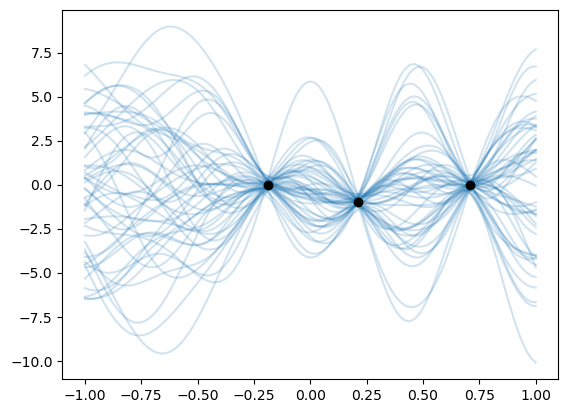

In [206]:
def exact_logp_wrapper(t, yt, x):
    # fn = lambda y_: reverse_drift_ode(t, y_, x)
    fn = lambda y_: reverse_drift_ode(t, y_[..., None], x).reshape(-1)
    f, vjp_fn = jax.vjp(fn, yt.reshape(-1))
    size = yt.shape[0]  # this implementation only works for 1D input
    eye = jnp.eye(size)
    (dfdy,) = jax.vmap(vjp_fn)(eye)
    logp = jnp.trace(dfdy)
    return logp


def conditional_sample(key, x_context, y_context, x_test, num_steps: int, num_inner_steps: int):
    len_context = len(x_context)
    shape_augmented_state = [len(x_test) + len(x_context), 1]  # assume 1d output

    t0 = beta_schedule.t0
    t1 = beta_schedule.t1
    ts = jnp.linspace(t1, t0, num_steps, endpoint=True)
    dt = ts[0] - ts[1]

    solver = dfx.Euler()
    # reverse ODE:
    ode_terms_reverse = dfx.ODETerm(reverse_drift_ode)

    # reverse SDE:
    # shape = jax.ShapeDtypeStruct(shape_augmented_state, y_context.dtype)
    # key, subkey = jax.random.split(key)
    # bm = dfx.VirtualBrownianTree(t0=t1, t1=t0, tol=dt, shape=shape, key=subkey)
    # ode_terms_reverse = dfx.MultiTerm(dfx.ODETerm(reverse_drift_sde), dfx.ControlTerm(diffusion, bm))

    # forward SDE:
    shape = jax.ShapeDtypeStruct(shape_augmented_state, y_context.dtype)
    key, subkey = jax.random.split(key)
    bm = dfx.VirtualBrownianTree(t0=t0, t1=t1, tol=dt, shape=shape, key=subkey)
    sde_terms_forward = dfx.MultiTerm(dfx.ODETerm(drift), MatVecControlTerm(diffusion, bm))

    def inner_loop(key, yt, t):
        yt_context = sample_pt(key, x_context, t, y_context)
        yt_augmented = jnp.concatenate([yt_context, yt], axis=0)
        x_augmented = jnp.concatenate([x_context, x_test], axis=0)

        # reverse step
        yt_m_dt, *_ = solver.step(ode_terms_reverse, t, t - dt, yt_augmented, x_augmented, None, made_jump=False)

        # forward step
        yt, *_ = solver.step(sde_terms_forward, t - dt, t, yt_m_dt, x_augmented, None, made_jump=False)

        # strip context from augmented state
        return yt[len_context:], yt_m_dt[len_context:]

    def outer_loop(key, carry, t):
    # def outer_loop(key, yt, t):
        yt, logp = carry
        _, yt_m_dt = jax.lax.scan(lambda yt, key: inner_loop(key, yt, t), yt, jax.random.split(key, num_inner_steps))
        yt = yt_m_dt[-1]
        logp_delta = exact_logp_wrapper(t, yt, x_test)
        logp += logp_delta
        return (yt, logp), yt
        # return yt, yt


    key, subkey = jax.random.split(key)
    yT = sample_pt(subkey, x_test, 1.0)

    xs = (ts[:-1], jax.random.split(key, len(ts) - 1))
    # y0, traj = jax.lax.scan(lambda yt, x: outer_loop(x[1], yt, x[0]), yT, xs)
    (y0, logp), traj = jax.lax.scan(lambda yt, x: outer_loop(x[1], yt, x[0]), (yT, jnp.zeros(())), xs)
    traj = jnp.concatenate([yT[None, ...], traj], axis=0)
    # return y0, traj, ts
    return y0, logp, traj, ts


x_known = jnp.reshape(jnp.asarray([[-0.2, 0.2, 0.7]]), (-1, 1)) + 1e-2
y_known = jnp.reshape(jnp.asarray([[0.0, -1.0, 0.0]]), (-1, 1))
x_test = jnp.linspace(-1, 1, 101)[:, None]
key = jax.random.PRNGKey(0)
num_samples = 50
num_steps = 100
num_inner_steps = 10
samples, logp, traj, ts = jax.vmap(lambda key: conditional_sample(key, x_known, y_known, x_test, num_steps, num_inner_steps))(jax.random.split(key, num_samples))
print(logp)

# %%
plt.figure()
# plt.plot(x_test, samples[..., 0].T, "C0", alpha=.2)
plt.plot(x_test, traj[:, -1, :].reshape(num_samples, -1).T, "C0", alpha=.2)
plt.plot(x_known, y_known, "ko")
plt.show()

In [113]:
# Log likelihood evaluation
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions


def approx_logp_wrapper(t, carry, static_args):
    yt, _ = carry
    eps, x = static_args

    fn = lambda y_: reverse_drift_ode(t, y_, x)
    drift_yt, vjp_fn = jax.vjp(fn, yt)
    (eps_dfdy,) = vjp_fn(eps)
    grad_logp = jnp.sum(eps_dfdy * eps)

    return drift_yt, grad_logp

def exact_logp_wrapper(t, carry, static_args):
    yt, _ = carry
    _, x = static_args
    # fn = lambda y_: reverse_drift_ode(t, y_, x)
    fn = lambda y_: reverse_drift_ode(t, y_[..., None], x).reshape(-1)
    f, vjp_fn = jax.vjp(fn, yt.reshape(-1))
    size = yt.shape[0]  # this implementation only works for 1D input
    eye = jnp.eye(size)
    (dfdy,) = jax.vmap(vjp_fn)(eye)
    logp = jnp.trace(dfdy)
    return f[..., None], logp

key, ykey, ekey = jax.random.split(key, 3)
# term = dfx.ODETerm(approx_logp_wrapper)
term = dfx.ODETerm(exact_logp_wrapper)
x_test = jnp.linspace(-1, 1, 101)[:, None]

delta_logp [-602.74826933 -602.74828829 -602.74831739]
logp_prior [-146.76935375 -141.97895962 -135.46011638]
logp_sample_prob_flow [455.97891558 460.76932867 467.28820101]
true_logp_sample [455.94774954 459.63373642 465.81289428]


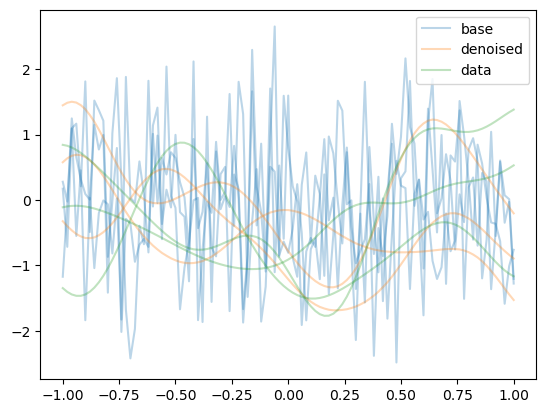

In [114]:
# solver = dfx.Tsit5()
solver = dfx.Dopri5()
t0 = beta_schedule.t0
t1 = beta_schedule.t1
dt = 1e-3/2
# dt = 0.1
from diffrax import PIDController, ConstantStepSize
# stepsize_controller = ConstantStepSize()
stepsize_controller = PIDController(rtol=1e-6, atol=1e-6)


prior = tfd.MultivariateNormalFullCovariance(
    loc=mean_function(x_test).reshape(-1),
    covariance_matrix=k1(x_test),
)
yT = prior.sample(seed=key, sample_shape=(num_samples,))[..., None]
logp_prior = prior.log_prob(yT.reshape(num_samples, -1))
ys = sample_gp(subkey, k0, mean_function, x_test, num_samples=num_samples)
eps = jax.random.normal(ekey, yT[0].shape)

# Generate sample along with associated log-likelihood
sol = jax.vmap(lambda y: dfx.diffeqsolve(
    term, solver, t1, 3e-4, -dt, (y, 0.), (eps, x_test), stepsize_controller=stepsize_controller
))(yT)
y0, delta_logp = sol.ys
y0, delta_logp = y0.reshape(num_samples, -1), delta_logp.reshape(num_samples)
plt.plot(x_test.reshape(-1), yT.reshape(num_samples, -1).T, color="C0", alpha=0.3)
plt.plot(x_test.reshape(-1), y0.T, color="C1", alpha=0.3)
plt.plot(x_test.reshape(-1), ys.reshape(num_samples, -1).T, color="C2", alpha=0.3)
plt.plot((), (), color="C0", alpha=0.3, label="base")
plt.plot((), (), color="C1", alpha=0.3, label="denoised")
plt.plot((), (), color="C2", alpha=0.3, label="data")
plt.legend()
print("delta_logp", delta_logp)
# %%

print("logp_prior", logp_prior)
logp_sample_prob_flow = logp_prior - delta_logp

prob0 = tfd.MultivariateNormalFullCovariance(
    loc=mean_function(x_test).reshape(-1),
    covariance_matrix=k0(x_test) + 1e-6 * jnp.eye(len(x_test)),
)
true_logp_sample = prob0.log_prob(y0.reshape(num_samples, -1))
print("logp_sample_prob_flow", logp_sample_prob_flow)
print("true_logp_sample", true_logp_sample)

delta_logp [602.75062771 602.7506901  602.75063697 602.7507877  602.75059086
 602.75060168 602.75066649 602.75072253 602.75066814 602.75073701]
logp_prior [-140.4838054  -165.89698556 -160.05265091 -141.37720819 -138.06500333
 -153.36794429 -147.49810649 -144.70968191 -152.65926924 -153.82898794]
logp_sample_prob_flow [462.26682231 436.85370454 442.69798607 461.37357951 464.68558753
 449.38265739 455.25256    458.04104062 450.0913989  448.92174907]
true_logp_sample [461.56638684 438.84517541 444.47167606 459.94844533 463.65702323
 450.51723576 455.66407291 458.05987106 451.16394469 449.57844985]


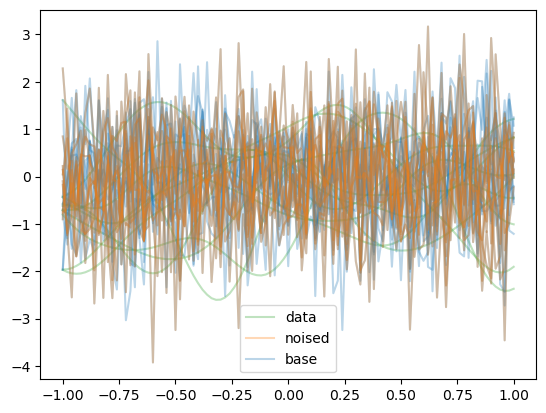

In [116]:
# Evaluate data log-likelihood

dt = 1e-3/2
# dt = 0.1
# solver = dfx.Tsit5()
solver = dfx.Dopri5()
# stepsize_controller = ConstantStepSize()
stepsize_controller = PIDController(rtol=1e-6, atol=1e-6)


num_samples = 10

prob0 = tfd.MultivariateNormalFullCovariance(
    loc=mean_function(x_test).reshape(-1),
    covariance_matrix=k0(x_test) + 1e-6 * jnp.eye(len(x_test)),
)
y0 = prob0.sample(seed=key, sample_shape=(num_samples,))[..., None]
true_logp_sample = prob0.log_prob(y0.reshape(num_samples, -1))

sol = jax.vmap(lambda y: dfx.diffeqsolve(
    term, solver, 3e-4, t1, dt, (y, 0.), (eps, x_test), stepsize_controller=stepsize_controller
))(y0)
yT, delta_logp = sol.ys

yT, delta_logp = yT.reshape(num_samples, -1), delta_logp.reshape(num_samples)
plt.plot(x_test.reshape(-1), yT.T, color="C0", alpha=0.3)
print("delta_logp", delta_logp)
# # %%
# ys = sample_gp(subkey, k1, mean_function, x_test, num_samples=num_samples).reshape(num_samples, -1)
prior = tfd.MultivariateNormalFullCovariance(
    loc=mean_function(x_test).reshape(-1),
    covariance_matrix=k1(x_test),
)
logp_prior = prior.log_prob(yT)
print("logp_prior", logp_prior)
ys = prior.sample(seed=key, sample_shape=(num_samples,))
plt.plot(x_test.reshape(-1), y0.reshape(num_samples, -1).T, color="C2", alpha=0.3)
plt.plot(x_test.reshape(-1), ys.T, color="C0", alpha=0.3)
plt.plot(x_test.reshape(-1), yT.reshape(num_samples, -1).T, color="C1", alpha=0.3)
plt.plot((), (), color="C2", alpha=0.3, label="data")
plt.plot((), (), color="C1", alpha=0.3, label="noised")
plt.plot((), (), color="C0", alpha=0.3, label="base")
plt.legend()
logp_sample_prob_flow = logp_prior + delta_logp

print("logp_sample_prob_flow", logp_sample_prob_flow)
print("true_logp_sample", true_logp_sample)

In [101]:
import math
import jax.scipy as jsp
from einops import rearrange
gram = ndp.kernels.gram

class MultivariateNormalDistribution:
    def __init__(self, mean, scale, **kwargs):
        # TODO: should we reshape mean (B, N, D) -> (B, N*D)
        # and scale                    (B, N, N, D, D) -> (B, N*D, N*D) ?
        self.mean = mean
        self.scale = scale

    def sample(self, seed, sample_shape):
        z = jax.random.normal(seed, (*sample_shape, *self.mean.shape))
        bijector = lambda z: self.mean + jnp.einsum("...ij,...j->...i", self.scale, z)
        bijector = jax.vmap(bijector) if sample_shape != () else bijector
        return bijector(z)

    def log_prob(self, z):
        shape = z.shape
        M = jsp.linalg.solve_triangular(self.scale, z - self.mean, lower=True)
        M = jnp.power(M, 2).sum(-1)
        diag = jnp.diag if len(shape) == 1 else jax.vmap(jnp.diag)
        half_log_det = jnp.log(diag(self.scale)).sum(-1)
        logp = -0.5 * (shape[-1] * math.log(2 * math.pi) + M) - half_log_det
        return logp


def gp_prior(mean_fn, kernel, x, noise=0.0):
    shape = x.shape
    n_test = shape[-2]
    μt = mean_fn(x)
    μt = rearrange(μt, "... n d -> ... (n d)")
    gram_kernel = kernel
    Ktt = jax.vmap(gram_kernel)(x) if len(shape) > 2 else gram_kernel(x)
    Ktt += (JITTER + noise) * jnp.eye(n_test)  # shape = [b (n d) (n d)]
    # scale = jnp.linalg.cholesky(Ktt)
    dist = tfd.MultivariateNormalFullCovariance(loc=μt, covariance_matrix=Ktt)
    return dist

def gp_posterior(
    mean_fn,
    kernel,
    x,
    y,
    x_eval,
    noise=0.0,
):
    shape = x.shape
    print(shape)
    n = shape[-2]
    μx = mean_fn(x)
    y = rearrange(y, "... n d -> ... (n d)")
    μx = rearrange(μx, "... n d -> ... (n d)")
    gram_kernel = kernel
    Kxx = jax.vmap(gram_kernel)(x) if len(shape) > 2 else gram_kernel(x)
    Kxx += (JITTER + noise) * jnp.eye(n)  # shape = [b (n d) (n d)]
    L = jnp.linalg.cholesky(Kxx)  # shape = [b (n d) (n d)]
    # w = L⁻¹ (y - μx)
    w = jsp.linalg.solve_triangular(L, y - μx, lower=True)  # shape = [b (n d)]
    μt = mean_fn(x_eval)  # shape = [b n d]
    μt = rearrange(μt, "... n d -> ... (n d)")  # shape = [b (n d)]
    shape = x_eval.shape
    n_test = shape[-2]
    Ktt = jax.vmap(gram_kernel)(x_eval) if len(shape) > 2 else gram_kernel(x_eval)
    # Kxt = jax.vmap(gram_kernel)(x, x_eval) if len(shape) > 2 else gram_kernel(x, x_eval)
    # if len(x.shape) <= 2 and len(x_eval.shape) <= 2:
    Kxt = gram_kernel(x, x_eval)
    # L⁻¹ Kxt
    L_inv_Kxt = jsp.linalg.solve_triangular(L, Kxt, lower=True)  # shape = [b (n d) (m d)]
    # μt  +  Ktx (Kzz + Iσ²)⁻¹ (y  -  μx)
    L_inv_Kxt_T = jnp.einsum("...ij->...ji", L_inv_Kxt)  # shape = [b (m d) (n d)]
    # mean = μt + jnp.einsum("...ji,...j->...i", L_inv_Kxt, w)
    mean = μt + jnp.einsum("...ij,...j->...i", L_inv_Kxt_T, w)  # shape = [b (m d)]
    # Ktt  -  Ktz (Kzz + Iσ²)⁻¹ Kxt  [recall (Kzz + Iσ²)⁻¹ = (LLᵀ)⁻¹ =  L⁻ᵀL⁻¹]
    covariance = Ktt - jnp.einsum("...ij,...jk->...ik", L_inv_Kxt_T, L_inv_Kxt)
    covariance += (JITTER + noise) * jnp.eye(n_test)  # shape = [b (m d) (m d)]

    # scale = jnp.linalg.cholesky(covariance)
    # dist = MultivariateNormalDistribution(mean, scale)
    dist = tfd.MultivariateNormalFullCovariance(loc=mean, covariance_matrix=covariance)
    return dist

(3, 1)


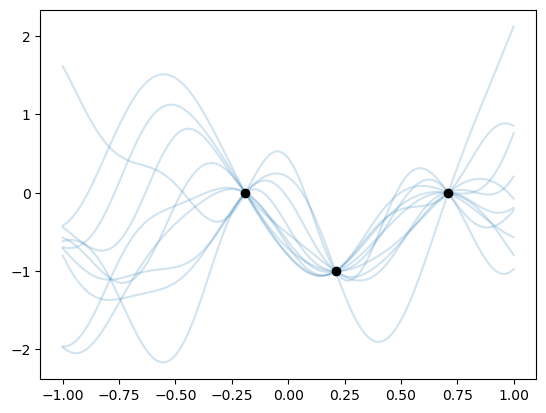

Gaussian process
[-3.25941984]
[1040.92169092 1018.19716801 1023.83612863 1039.3123143  1043.01775544
 1029.88035165 1035.01813821 1037.41398684 1030.53352461 1028.94519328]
[1044.18111075 1021.45658784 1027.09554847 1042.57173414 1046.27717527
 1033.13977148 1038.27755804 1040.67340668 1033.79294445 1032.20461312]
[1044.18579156 1021.46464174 1027.09098682 1042.56777626 1046.27642385
 1033.13659586 1038.28340963 1040.67930965 1033.78337877 1032.19771463]
diffusion process
[-3.25941631]
[1041.00101447 1018.26304687 1023.88231244 1039.39117397 1043.10088223
 1029.9341477  1035.10815875 1037.49932143 1030.58292678 1029.01240458]
[1044.26043078 1021.52246317 1027.14172875 1042.65059028 1046.36029854
 1033.19356401 1038.36757506 1040.75873774 1033.84234309 1032.27182088]


In [102]:
num_samples = 10
prob0_cond = gp_posterior(mean_function, k0, x_known, y_known, x_test)
y0 = prob0_cond.sample(seed=key, sample_shape=(num_samples,))[..., None]
true_prob0_cond = prob0_cond.log_prob(y0.reshape(num_samples, -1))

plt.figure()
plt.plot(x_test, y0[..., 0].T, "C0", alpha=.2)
plt.plot(x_known, y_known, "ko")
plt.show()

x_augmented = jnp.concatenate([x_known, x_test], axis=0)
y_augmented = jnp.concatenate([jnp.repeat(y_known[None, ...], num_samples, 0), y0], axis=1)
prob0_joint = gp_prior(mean_function, k0, x_augmented).log_prob(y_augmented.reshape(num_samples, -1))
prob0_known = gp_prior(mean_function, k0, x_known).log_prob(y_known.reshape(1, -1))
diff_prob0_cond = prob0_joint - prob0_known

print("Gaussian process")
print(prob0_known)
print(prob0_joint)
print(diff_prob0_cond)
print(true_prob0_cond)

dt = 1e-3/2
# dt = 0.1
# solver = dfx.Tsit5()
solver = dfx.Dopri5()
# stepsize_controller = ConstantStepSize()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol = jax.vmap(lambda y: dfx.diffeqsolve(term, solver, 1e-5, t1, dt, (y, 0.), (eps, x_augmented), stepsize_controller=stepsize_controller))(y_augmented)
yT, delta_logp = sol.ys
yT, delta_logp = yT.reshape(num_samples, -1), delta_logp.reshape(num_samples)
prior = tfd.MultivariateNormalFullCovariance(loc=mean_function(x_augmented).reshape(-1),covariance_matrix=k1(x_augmented),)
logp_prior = prior.log_prob(yT)
prob_joint = logp_prior + delta_logp

sol = dfx.diffeqsolve(term, solver, 3e-4, t1, dt, (y_known, 0.), (eps, x_known), stepsize_controller=stepsize_controller)
yT, delta_logp = sol.ys
yT, delta_logp = yT.reshape(1, -1), delta_logp.reshape(1)
prior = tfd.MultivariateNormalFullCovariance(loc=mean_function(x_known).reshape(-1),covariance_matrix=k1(x_known),)
logp_prior = prior.log_prob(yT)
prob_known = logp_prior + delta_logp

# print(prob_known)
diff_prob_cond = prob_joint - prob_known
print("diffusion process")
print(prob_known)
print(prob_joint)
print(diff_prob_cond)


(50, 100)
(50, 100, 101, 1)
[348.62080883 348.62080883 348.62080883 348.62080883 348.62080883
 348.62080883 348.62080883 348.62080883 348.62080883 348.62080883
 348.62080883 348.62080883 348.62080883 348.62080883 348.62080883
 348.62080883 348.62080883 348.62080883 348.62080883 348.62080883
 348.62080883 348.62080883 348.62080883 348.62080883 348.62080883
 348.62080883 348.62080883 348.62080883 348.62080883 348.62080883
 348.62080883 348.62080883 348.62080883 348.62080883 348.62080883
 348.62080883 348.62080883 348.62080883 348.62080883 348.62080883
 348.62080883 348.62080883 348.62080883 348.62080883 348.62080883
 348.62080883 348.62080883 348.62080883 348.62080883 348.62080883]
[-141.33170622 -150.57544117 -159.91613636 -151.8697567  -147.08208805
 -140.20557262 -146.50503938 -136.87949108 -134.99388349 -142.89388393
 -145.57565366 -144.88450113 -148.92028671 -146.16967531 -150.95324007
 -147.14306106 -153.23765473 -142.07032397 -149.63401468 -152.51297457
 -137.19086328 -141.5841787

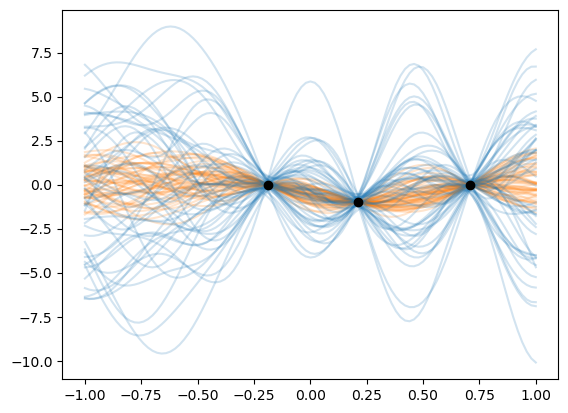

In [207]:
t0 = beta_schedule.t0
t1 = beta_schedule.t1
print(ts.shape)
print(traj.shape)

def exact_logp_wrapper(t, yt, x):
    # fn = lambda y_: reverse_drift_ode(t, y_, x)
    fn = lambda y_: reverse_drift_ode(t, y_[..., None], x).reshape(-1)
    f, vjp_fn = jax.vjp(fn, yt.reshape(-1))
    size = yt.shape[0]  # this implementation only works for 1D input
    eye = jnp.eye(size)
    (dfdy,) = jax.vmap(vjp_fn)(eye)
    logp = jnp.trace(dfdy)
    return logp


delta_logp = jax.vmap(lambda ts, ys: jax.vmap(lambda t, y: exact_logp_wrapper(t, y, x_test))(ts, ys))(ts[:, :-1], traj[:, 1:, ...])
delta_logp = jnp.sum(delta_logp, axis=-1) * (t1 - t0) / num_steps # approximate change of log likelihood
print(delta_logp)


prior = tfd.MultivariateNormalFullCovariance(loc=mean_function(x_test).reshape(-1), covariance_matrix=k1(x_test))
logp_prior = prior.log_prob(traj[:, 0, :].reshape(num_samples, -1))
print(logp_prior)
logp_sample_prob_flow = logp_prior + delta_logp
print(logp_sample_prob_flow)

# y_augmented = jnp.concatenate([jnp.repeat(y_known[None, ...], num_samples, 0), traj[:, -1, ...]], axis=1)
y_augmented = jnp.concatenate([jnp.repeat(y_known[None, ...], num_samples, 0), samples], axis=1)
sol = jax.vmap(lambda y: dfx.diffeqsolve(term, solver, 1e-5, t1, dt, (y, 0.), (eps, x_augmented), stepsize_controller=stepsize_controller))(y_augmented)
yT, delta_logp = sol.ys
yT, delta_logp = yT.reshape(num_samples, -1), delta_logp.reshape(num_samples)
prior = tfd.MultivariateNormalFullCovariance(loc=mean_function(x_augmented).reshape(-1),covariance_matrix=k1(x_augmented),)
logp_prior = prior.log_prob(yT)
prob_joint = logp_prior + delta_logp

sol = dfx.diffeqsolve(term, solver, 3e-4, t1, dt, (y_known, 0.), (eps, x_known), stepsize_controller=stepsize_controller)
yT, delta_logp = sol.ys
yT, delta_logp = yT.reshape(1, -1), delta_logp.reshape(1)
prior = tfd.MultivariateNormalFullCovariance(loc=mean_function(x_known).reshape(-1),covariance_matrix=k1(x_known),)
logp_prior = prior.log_prob(yT)
prob_known = logp_prior + delta_logp

diff_prob_cond = prob_joint - prob_known
print("diffusion process")
print(prob_known)
print(prob_joint)
print(diff_prob_cond)


print("gaussian process")
prob0_cond = gp_posterior(mean_function, k0, x_known, y_known, x_test)
y0 = prob0_cond.sample(seed=key, sample_shape=(num_samples,))[..., None]
true_prob0_cond = prob0_cond.log_prob(traj[:, -1, ...].reshape(num_samples, -1))
print(true_prob0_cond)
# true_prob0_cond = prob0_cond.log_prob(y0.reshape(num_samples, -1))
# print(true_prob0_cond)


plt.figure()
plt.plot(x_test, y0[..., 0].T, "C1", alpha=.2)
plt.plot(x_test, traj[:, -1, :].reshape(num_samples, -1).T, "C0", alpha=.2)
plt.plot(x_known, y_known, "ko")
plt.show()